In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

2516


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 200


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [8]:
%%time
for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_hot_pixels_3D()
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _ref_cls._corr_hot_pixels_3D()
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=64, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.314s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.149s.
-- corrected illumination for channel 488 in 4.250s.
-- corrected illumination for channel 405 in 4.251s.
- Finished illumination correction in 12.829s.
Initi

	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.187s.
-- corrected illumination for channel 488 in 4.248s.
-- corrected illumination for channel 405 in 4.261s.
- Finished illumination correction in 12.932s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_004.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.623s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.227s.
-- corrected illumination for channel 488 in 1.077s.
- Finished illumination correction in 2.383s.
+ Calculate drift with drift_channel: 488
-- start aligning given sou

-- corrected illumination for channel 750 in 1.185s.
-- corrected illumination for channel 488 in 1.112s.
- Finished illumination correction in 2.406s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -16.13 -17.9 ] in 0.641s.
-- drift 1: [ 1.000e-02 -1.599e+01 -1.785e+01] in 0.565s.
-- drift 2: [  0.02 -16.03 -17.9 ] in 0.585s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.66666667e-02 -1.60500000e+01 -1.78833333e+01] for channel: 750
-- finish warpping channel 750 in 16.554s.
488 False True
-- warp image with drift:[ 1.66666667e-02 -1.60500000e+01 -1.78833333e+01] for channel: 488
-- finish warpping channel 488 in 16.593s.
-- finish warpping in 33.146s.
- apply microscope corrections
- run Cellpose segmentation in 37.534s.
(13, 2048, 2048) 7
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_bra

-- warp image with drift:[ -0.16666667 -16.62666667   9.00666667] for channel: 750
-- finish warpping channel 750 in 16.891s.
488 False True
-- warp image with drift:[ -0.16666667 -16.62666667   9.00666667] for channel: 488
-- finish warpping channel 488 in 17.578s.
-- finish warpping in 34.469s.
- apply microscope corrections
- run Cellpose segmentation in 37.110s.
(13, 2048, 2048) 10
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_10.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_011.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_011.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_011.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.775s.
- Correct illumin

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.688s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.253s.
-- corrected illumination for channel 488 in 4.303s.
-- corrected illumination for channel 405 in 4.396s.
- Finished illumination correction in 13.098s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_014.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.631s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

-- corrected illumination for channel 405 in 4.250s.
- Finished illumination correction in 12.828s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_017.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.813s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.079s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.266s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02 -17.05   3.69] in 0.516s.
-- drift 1: [ -0.02 -17.     3.85] in 0.594s.
-- drift 2: [ -0.02 -16.99

-- corrected illumination for channel 750 in 1.109s.
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 2.281s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.737e+01 -1.778e+01] in 0.515s.
-- drift 1: [  0.02 -17.26 -17.77] in 0.562s.
-- drift 2: [ 1.000e-02 -1.720e+01 -1.783e+01] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -1.72766667e+01 -1.77933333e+01] for channel: 750
-- finish warpping channel 750 in 17.038s.
488 False True
-- warp image with drift:[ 1.33333333e-02 -1.72766667e+01 -1.77933333e+01] for channel: 488
-- finish warpping channel 488 in 16.509s.
-- finish warpping in 33.547s.
- apply microscope corrections
- run Cellpose segmentation in 37.449s.
(13, 2048, 2048) 20
- save to file: \\10.245.74.158\Chromatin_NAS_0\2

-- warp image with drift:[-1.000e-02 -1.739e+01  3.180e+00] for channel: 750
-- finish warpping channel 750 in 16.709s.
488 False True
-- warp image with drift:[-1.000e-02 -1.739e+01  3.180e+00] for channel: 488
-- finish warpping channel 488 in 16.410s.
-- finish warpping in 33.119s.
- apply microscope corrections
- run Cellpose segmentation in 35.125s.
(13, 2048, 2048) 23
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_23.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_024.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_024.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.966s.
- Correct illumination for ch

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.444s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.189s.
-- corrected illumination for channel 488 in 4.298s.
-- corrected illumination for channel 405 in 4.445s.
- Finished illumination correction in 13.102s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_027.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.770s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

-- corrected illumination for channel 405 in 4.203s.
- Finished illumination correction in 13.168s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_030.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.641s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.172s.
-- corrected illumination for channel 488 in 1.129s.
- Finished illumination correction in 2.395s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.550e+01 -2.424e+01] in 0.556s.
-- drift 1: [-2.000e-02 -1.534e+01 -2.406e+01] in 0.594s.
--

-- corrected illumination for channel 750 in 1.111s.
-- corrected illumination for channel 488 in 1.092s.
- Finished illumination correction in 2.351s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -15.55 -23.39] in 0.547s.
-- drift 1: [ -0.07 -15.45 -23.17] in 0.584s.
-- drift 2: [ -0.04 -15.36 -23.3 ] in 0.573s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04666667 -15.45333333 -23.28666667] for channel: 750
-- finish warpping channel 750 in 16.423s.
488 False True
-- warp image with drift:[ -0.04666667 -15.45333333 -23.28666667] for channel: 488
-- finish warpping channel 488 in 16.576s.
-- finish warpping in 32.999s.
- apply microscope corrections
- run Cellpose segmentation in 35.609s.
(13, 2048, 2048) 33
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segme

-- finish warpping channel 750 in 16.354s.
488 False True
-- warp image with drift:[ -0.04       -18.34666667  -2.23      ] for channel: 488
-- finish warpping channel 488 in 16.405s.
-- finish warpping in 32.759s.
- apply microscope corrections
- run Cellpose segmentation in 34.988s.
(13, 2048, 2048) 36
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_36.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_037.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_037.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.470s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] f

- Loaded images for channels:['750', '488', '405'] in 2.603s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.180s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 12.844s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_040.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.656s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction pr

- Loaded images for channels:['750', '488'] in 0.718s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.125s.
-- corrected illumination for channel 488 in 1.140s.
- Finished illumination correction in 2.281s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.644e+01 -4.690e+00] in 0.547s.
-- drift 1: [  0.   -16.45  -4.69] in 0.547s.
-- drift 2: [  0.   -16.44  -4.65] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.64433333e+01 -4.67666667e+00] for channel: 750
-- finish warpping channel 750 in 16.301s.
488 False True
-- wa

-- drift 0: [-1.00e-02 -1.54e+01 -7.52e+00] in 0.545s.
-- drift 1: [ -0.02 -15.4   -7.3 ] in 0.606s.
-- drift 2: [ -0.02 -15.24  -7.45] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.01666667 -15.34666667  -7.42333333] for channel: 750
-- finish warpping channel 750 in 16.325s.
488 False True
-- warp image with drift:[ -0.01666667 -15.34666667  -7.42333333] for channel: 488
-- finish warpping channel 488 in 16.359s.
-- finish warpping in 32.684s.
- apply microscope corrections
- run Cellpose segmentation in 36.468s.
(13, 2048, 2048) 46
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_46.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_047.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_047.dax
Initialize DaxProcesser 

-- finish warpping channel 488 in 16.375s.
-- finish warpping in 32.686s.
- apply microscope corrections
- run Cellpose segmentation in 35.969s.
(13, 2048, 2048) 49
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_49.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.325s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illuminatio

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.032s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.254s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.282s.
- Finished illumination correction in 12.953s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.625s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

-- corrected illumination for channel 405 in 4.265s.
- Finished illumination correction in 12.860s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_056.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.623s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.203s.
-- corrected illumination for channel 488 in 1.080s.
- Finished illumination correction in 2.298s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.08 -16.01  -4.34] in 0.540s.
-- drift 1: [ -0.09 -15.87  -4.05] in 0.538s.
-- drift 2: [ -0.13 -15.85

-- corrected illumination for channel 750 in 1.094s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.262s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02 -13.22  -2.1 ] in 0.563s.
-- drift 1: [ -0.03 -13.1   -1.91] in 0.531s.
-- drift 2: [ -0.02 -13.07  -1.92] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.02333333 -13.13        -1.97666667] for channel: 750
-- finish warpping channel 750 in 16.250s.
488 False True
-- warp image with drift:[ -0.02333333 -13.13        -1.97666667] for channel: 488
-- finish warpping channel 488 in 16.359s.
-- finish warpping in 32.609s.
- apply microscope corrections
- run Cellpose segmentation in 34.549s.
(13, 2048, 2048) 59
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segme

-- warp image with drift:[-1.00000000e-02 -1.40933333e+01 -2.07366667e+01] for channel: 750
-- finish warpping channel 750 in 16.286s.
488 False True
-- warp image with drift:[-1.00000000e-02 -1.40933333e+01 -2.07366667e+01] for channel: 488
-- finish warpping channel 488 in 16.390s.
-- finish warpping in 32.676s.
- apply microscope corrections
- run Cellpose segmentation in 36.313s.
(13, 2048, 2048) 62
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_62.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_063.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_063.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_063.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.486s.

\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_066.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_066.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.438s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.255s.
-- corrected illumination for channel 488 in 4.343s.
-- corrected illumination for channel 405 in 4.366s.
- Finished illumination correction in 13.151s.
Initi

	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.306s.
-- corrected illumination for channel 405 in 4.225s.
- Finished illumination correction in 12.951s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_069.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.767s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.078s.
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 2.295s.
+ Calculate drift with drift_channel: 488
-- start aligning given sou

-- corrected illumination for channel 750 in 1.174s.
-- corrected illumination for channel 488 in 1.104s.
- Finished illumination correction in 2.414s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.432e+01 -3.240e+00] in 0.581s.
-- drift 1: [-1.000e-02 -1.413e+01 -3.190e+00] in 0.547s.
-- drift 2: [-1.000e-02 -1.412e+01 -3.190e+00] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.41900000e+01 -3.20666667e+00] for channel: 750
-- finish warpping channel 750 in 16.296s.
488 False True
-- warp image with drift:[-1.00000000e-02 -1.41900000e+01 -3.20666667e+00] for channel: 488
-- finish warpping channel 488 in 16.353s.
-- finish warpping in 32.649s.
- apply microscope corrections
- run Cellpose segmentation in 36.484s.
(13, 2048, 2048) 72
- save to file: \\10.245.74.158\Chrom

-- drift 0: [ -0.03 -13.9   -4.05] in 0.547s.
-- drift 1: [-1.00e-02 -1.39e+01 -4.00e+00] in 0.594s.
-- drift 2: [-1.000e-02 -1.381e+01 -4.130e+00] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.01666667 -13.87        -4.06      ] for channel: 750
-- finish warpping channel 750 in 16.188s.
488 False True
-- warp image with drift:[ -0.01666667 -13.87        -4.06      ] for channel: 488
-- finish warpping channel 488 in 16.437s.
-- finish warpping in 32.625s.
- apply microscope corrections
- run Cellpose segmentation in 32.922s.
(13, 2048, 2048) 75
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_75.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_076.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_076.dax
Initialize D

- run Cellpose segmentation in 34.797s.
(13, 2048, 2048) 78
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_78.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_079.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_079.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.391s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination 

- Loaded images for channels:['750', '488', '405'] in 2.283s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.155s.
-- corrected illumination for channel 488 in 4.265s.
-- corrected illumination for channel 405 in 4.235s.
- Finished illumination correction in 12.907s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_082.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.718s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction pr

- Loaded images for channels:['750', '488'] in 0.675s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.113s.
-- corrected illumination for channel 488 in 1.117s.
- Finished illumination correction in 2.355s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.44 -13.82  -9.87] in 0.549s.
-- drift 1: [-1.000e-02 -1.379e+01 -9.520e+00] in 0.565s.
-- drift 2: [ -0.35 -12.79 -10.77] in 0.519s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.26666667 -13.46666667 -10.05333333] for channel: 750
-- finish warpping channel 750 in 16.201s.
488 False True
-- warp image 

-- drift 0: [ -0.02 -12.1   -1.32] in 0.546s.
-- drift 1: [  0.   -11.9   -1.28] in 0.578s.
-- drift 2: [ -0.03 -11.98  -1.34] in 0.532s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.01666667 -11.99333333  -1.31333333] for channel: 750
-- finish warpping channel 750 in 16.174s.
488 False True
-- warp image with drift:[ -0.01666667 -11.99333333  -1.31333333] for channel: 488
-- finish warpping channel 488 in 16.263s.
-- finish warpping in 32.437s.
- apply microscope corrections
- run Cellpose segmentation in 37.391s.
(13, 2048, 2048) 88
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_88.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_089.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_089.dax
Initialize DaxProcesser for file:

-- finish warpping channel 488 in 16.266s.
-- finish warpping in 32.544s.
- apply microscope corrections
- run Cellpose segmentation in 33.781s.
(13, 2048, 2048) 91
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_91.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_092.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.589s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illuminatio

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.594s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.170s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.204s.
- Finished illumination correction in 12.751s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488']
-- single image size: 

-- corrected illumination for channel 750 in 4.205s.
-- corrected illumination for channel 488 in 4.248s.
-- corrected illumination for channel 405 in 4.221s.
- Finished illumination correction in 12.893s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_098.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.594s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.141s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.312s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: 

-- corrected illumination for channel 750 in 1.094s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.296s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -12.08 -24.41] in 0.547s.
-- drift 1: [  0.   -11.91 -24.32] in 0.531s.
-- drift 2: [  0.   -11.87 -24.41] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.         -11.95333333 -24.38      ] for channel: 750
-- finish warpping channel 750 in 16.359s.
488 False True
-- warp image with drift:[  0.         -11.95333333 -24.38      ] for channel: 488
-- finish warpping channel 488 in 16.391s.
-- finish warpping in 32.750s.
- apply microscope corrections
- run Cellpose segmentation in 37.500s.
(13, 2048, 2048) 101
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segm

-- warp image with drift:[ 1.00000000e-02 -1.41900000e+01 -8.94666667e+00] for channel: 750
-- finish warpping channel 750 in 16.275s.
488 False True
-- warp image with drift:[ 1.00000000e-02 -1.41900000e+01 -8.94666667e+00] for channel: 488
-- finish warpping channel 488 in 16.379s.
-- finish warpping in 32.654s.
- apply microscope corrections
- run Cellpose segmentation in 37.609s.
(13, 2048, 2048) 104
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_104.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_105.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_105.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_105.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.763

-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.309s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.234s.
-- corrected illumination for channel 488 in 4.187s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.859s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_108.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.766s.
- Correct illumination for channels: ['750', '488']
-- 

	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.222s.
-- corrected illumination for channel 488 in 4.278s.
-- corrected illumination for channel 405 in 4.265s.
- Finished illumination correction in 12.969s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_111.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.656s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.141s.
-- corrected illumination for channel 488 in 1.127s.
- Finished illumination correction in 2.408s.
+ Calculate drift with drift_channel: 488
-- start aligning given sou

-- corrected illumination for channel 750 in 1.084s.
-- corrected illumination for channel 488 in 1.071s.
- Finished illumination correction in 2.250s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.08 -11.95 -24.45] in 0.578s.
-- drift 1: [ -0.06 -11.8  -24.31] in 0.547s.
-- drift 2: [ -0.06 -11.76 -24.42] in 0.604s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.06666667 -11.83666667 -24.39333333] for channel: 750
-- finish warpping channel 750 in 16.286s.
488 False True
-- warp image with drift:[ -0.06666667 -11.83666667 -24.39333333] for channel: 488
-- finish warpping channel 488 in 16.396s.
-- finish warpping in 32.682s.
- apply microscope corrections
- run Cellpose segmentation in 35.828s.
(13, 2048, 2048) 114
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segm

-- warp image with drift:[-1.00000000e-02 -1.17900000e+01 -2.22333333e+00] for channel: 750
-- finish warpping channel 750 in 16.250s.
488 False True
-- warp image with drift:[-1.00000000e-02 -1.17900000e+01 -2.22333333e+00] for channel: 488
-- finish warpping channel 488 in 16.345s.
-- finish warpping in 32.594s.
- apply microscope corrections
- run Cellpose segmentation in 36.404s.
(13, 2048, 2048) 117
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_117.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_118.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_118.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_118.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.546

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.085s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.211s.
-- corrected illumination for channel 488 in 4.222s.
-- corrected illumination for channel 405 in 4.234s.
- Finished illumination correction in 12.842s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488']
-- single image size: 

-- corrected illumination for channel 750 in 4.147s.
-- corrected illumination for channel 488 in 4.219s.
-- corrected illumination for channel 405 in 4.234s.
- Finished illumination correction in 12.793s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_124.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.687s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.078s.
-- corrected illumination for channel 488 in 1.063s.
- Finished illumination correction in 2.172s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: 

-- corrected illumination for channel 750 in 1.172s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.406s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -12.82 -23.76] in 0.535s.
-- drift 1: [ -0.06 -12.72 -23.6 ] in 0.543s.
-- drift 2: [ -0.04 -12.65 -23.74] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04333333 -12.73       -23.7       ] for channel: 750
-- finish warpping channel 750 in 16.246s.
488 False True
-- warp image with drift:[ -0.04333333 -12.73       -23.7       ] for channel: 488
-- finish warpping channel 488 in 16.343s.
-- finish warpping in 32.589s.
- apply microscope corrections
- run Cellpose segmentation in 37.234s.
(13, 2048, 2048) 127
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segm

-- warp image with drift:[  0.         -12.05666667 -14.56666667] for channel: 750
-- finish warpping channel 750 in 16.203s.
488 False True
-- warp image with drift:[  0.         -12.05666667 -14.56666667] for channel: 488
-- finish warpping channel 488 in 16.172s.
-- finish warpping in 32.374s.
- apply microscope corrections
- run Cellpose segmentation in 37.299s.
(13, 2048, 2048) 130
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_130.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.719s.
- Correct illum

\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_134.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.134s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.234s.
-- corrected illumination for channel 488 in 4.234s.
-- corrected illumination for channel 405 in 4.235s.
- Finished illumination correction in 12.891s.
Initi

-- corrected illumination for channel 750 in 4.197s.
-- corrected illumination for channel 488 in 4.234s.
-- corrected illumination for channel 405 in 4.235s.
- Finished illumination correction in 12.859s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.703s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.125s.
-- corrected illumination for channel 488 in 1.187s.
- Finished illumination correction in 2.422s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: 

-- corrected illumination for channel 750 in 1.078s.
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 2.297s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.83 -11.82  -2.94] in 0.562s.
-- drift 1: [ -0.75 -12.96  -3.49] in 0.594s.
-- drift 2: [ -0.83 -12.95  -3.42] in 0.703s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.80333333 -12.57666667  -3.28333333] for channel: 750
-- finish warpping channel 750 in 16.250s.
488 False True
-- warp image with drift:[ -0.80333333 -12.57666667  -3.28333333] for channel: 488
-- finish warpping channel 488 in 16.312s.
-- finish warpping in 32.562s.
- apply microscope corrections
- run Cellpose segmentation in 34.812s.
(13, 2048, 2048) 140
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segm

-- warp image with drift:[  0.         -14.11666667  -4.16      ] for channel: 750
-- finish warpping channel 750 in 16.216s.
488 False True
-- warp image with drift:[  0.         -14.11666667  -4.16      ] for channel: 488
-- finish warpping channel 488 in 16.265s.
-- finish warpping in 32.481s.
- apply microscope corrections
- run Cellpose segmentation in 36.031s.
(13, 2048, 2048) 143
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_143.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_144.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.335s.
- Correct illum

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.640s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.342s.
-- corrected illumination for channel 488 in 4.297s.
-- corrected illumination for channel 405 in 4.359s.
- Finished illumination correction in 13.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_147.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.594s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

-- corrected illumination for channel 405 in 4.158s.
- Finished illumination correction in 12.781s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_150.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.644s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.061s.
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 2.173s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.252e+01 -6.510e+00] in 0.569s.
-- drift 1: [  0.   -12.5   -6.21] in 0.581s.
-- drift 2: [-

-- corrected illumination for channel 750 in 1.083s.
-- corrected illumination for channel 488 in 1.112s.
- Finished illumination correction in 2.289s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.481e+01 -1.430e+00] in 0.566s.
-- drift 1: [-1.000e-02 -1.476e+01 -1.290e+00] in 0.566s.
-- drift 2: [  0.   -14.69  -1.34] in 0.582s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03 -1.47533333e+01 -1.35333333e+00] for channel: 750
-- finish warpping channel 750 in 16.295s.
488 False True
-- warp image with drift:[-6.66666667e-03 -1.47533333e+01 -1.35333333e+00] for channel: 488
-- finish warpping channel 488 in 16.357s.
-- finish warpping in 32.652s.
- apply microscope corrections
- run Cellpose segmentation in 38.236s.
(13, 2048, 2048) 153
- save to file: \\10.245.74.158\Chromatin_NAS_0\

-- warp image with drift:[-1.33333333e-02 -1.41700000e+01 -1.56666667e-01] for channel: 750
-- finish warpping channel 750 in 16.250s.
488 False True
-- warp image with drift:[-1.33333333e-02 -1.41700000e+01 -1.56666667e-01] for channel: 488
-- finish warpping channel 488 in 16.265s.
-- finish warpping in 32.515s.
- apply microscope corrections
- run Cellpose segmentation in 36.904s.
(13, 2048, 2048) 156
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_156.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_157.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_157.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_157.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.613

-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.256s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.185s.
-- corrected illumination for channel 488 in 4.234s.
-- corrected illumination for channel 405 in 4.235s.
- Finished illumination correction in 12.890s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_160.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.625s.
- Correct illumination for channels: ['750', '488']
-- 

-- corrected illumination for channel 750 in 4.640s.
-- corrected illumination for channel 488 in 4.720s.
-- corrected illumination for channel 405 in 4.644s.
- Finished illumination correction in 15.941s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_163.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.647s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.219s.
-- corrected illumination for channel 488 in 1.172s.
- Finished illumination correction in 2.422s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: 

-- corrected illumination for channel 750 in 1.112s.
-- corrected illumination for channel 488 in 1.175s.
- Finished illumination correction in 2.473s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04 -10.95  -3.37] in 0.555s.
-- drift 1: [ -0.04 -10.82  -3.22] in 0.563s.
-- drift 2: [ -0.05 -10.79  -3.37] in 0.612s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04333333 -10.85333333  -3.32      ] for channel: 750
-- finish warpping channel 750 in 16.403s.
488 False True
-- warp image with drift:[ -0.04333333 -10.85333333  -3.32      ] for channel: 488
-- finish warpping channel 488 in 16.549s.
-- finish warpping in 32.951s.
- apply microscope corrections
- run Cellpose segmentation in 38.141s.
(13, 2048, 2048) 166
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segm

-- warp image with drift:[ -0.04666667 -13.35333333  -0.10333333] for channel: 750
-- finish warpping channel 750 in 16.297s.
488 False True
-- warp image with drift:[ -0.04666667 -13.35333333  -0.10333333] for channel: 488
-- finish warpping channel 488 in 16.392s.
-- finish warpping in 32.690s.
- apply microscope corrections
- run Cellpose segmentation in 36.508s.
(13, 2048, 2048) 169
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_169.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_170.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_170.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_170.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.579s.
- Correct illum

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.528s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.236s.
-- corrected illumination for channel 488 in 4.356s.
-- corrected illumination for channel 405 in 4.281s.
- Finished illumination correction in 13.093s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_173.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.625s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

-- corrected illumination for channel 488 in 4.319s.
-- corrected illumination for channel 405 in 4.808s.
- Finished illumination correction in 13.581s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_176.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.629s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.206s.
-- corrected illumination for channel 488 in 1.174s.
- Finished illumination correction in 2.443s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -12.93   5.87] in 0.581s.
-- drift 1: [ -0.02

-- corrected illumination for channel 750 in 1.492s.
-- corrected illumination for channel 488 in 1.316s.
- Finished illumination correction in 2.950s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -10.81  -3.43] in 0.588s.
-- drift 1: [  0.02 -10.73  -3.37] in 0.612s.
-- drift 2: [ 1.000e-02 -1.076e+01 -3.260e+00] in 0.672s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.01666667 -10.76666667  -3.35333333] for channel: 750
-- finish warpping channel 750 in 16.844s.
488 False True
-- warp image with drift:[  0.01666667 -10.76666667  -3.35333333] for channel: 488
-- finish warpping channel 488 in 16.875s.
-- finish warpping in 33.718s.
- apply microscope corrections
- run Cellpose segmentation in 35.922s.
(13, 2048, 2048) 179
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_a

-- warp image with drift:[-3.33333333e-03 -1.22900000e+01 -1.96666667e-01] for channel: 750
-- finish warpping channel 750 in 16.247s.
488 False True
-- warp image with drift:[-3.33333333e-03 -1.22900000e+01 -1.96666667e-01] for channel: 488
-- finish warpping channel 488 in 16.219s.
-- finish warpping in 32.466s.
- apply microscope corrections
- run Cellpose segmentation in 36.562s.
(13, 2048, 2048) 182
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_182.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_183.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_183.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_183.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.297

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.766s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.312s.
-- corrected illumination for channel 488 in 4.219s.
-- corrected illumination for channel 405 in 4.453s.
- Finished illumination correction in 13.141s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_186.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.609s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

- Loaded images for channels:['750', '488'] in 0.656s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.078s.
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 2.360s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.  -12.5  -5.9] in 0.562s.
-- drift 1: [  0.   -12.28  -5.8 ] in 0.563s.
-- drift 2: [  0.   -12.38  -5.87] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.         -12.38666667  -5.85666667] for channel: 750
-- finish warpping channel 750 in 16.281s.
488 False True
-- warp image with drift:[  0

-- drift 0: [-0.04 -7.76 -4.6 ] in 0.625s.
-- drift 1: [-0.04 -7.61 -4.51] in 0.609s.
-- drift 2: [-0.05 -7.61 -4.49] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04333333 -7.66       -4.53333333] for channel: 750
-- finish warpping channel 750 in 16.297s.
488 False True
-- warp image with drift:[-0.04333333 -7.66       -4.53333333] for channel: 488
-- finish warpping channel 488 in 17.484s.
-- finish warpping in 33.781s.
- apply microscope corrections
- run Cellpose segmentation in 37.594s.
(13, 2048, 2048) 192
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_192.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_193.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_193.dax
Initialize DaxProcesser for file:\\10.245.74.1

- run Cellpose segmentation in 38.563s.
(13, 2048, 2048) 195
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_195.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_196.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_196.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_196.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.375s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illuminatio

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.423s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.315s.
-- corrected illumination for channel 488 in 4.344s.
-- corrected illumination for channel 405 in 4.311s.
- Finished illumination correction in 13.186s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_199.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.872s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination

## Check result

<IPython.core.display.Javascript object>


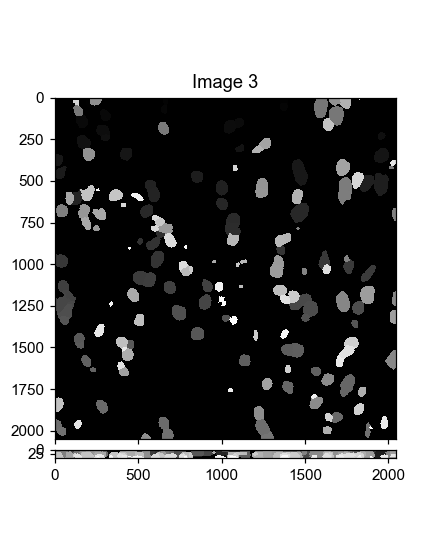

In [7]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])

## Watershed

In [9]:
print(segmentation_save_folder)

\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation


In [10]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [11]:
fovs

['Conv_zscan_000.dax',
 'Conv_zscan_001.dax',
 'Conv_zscan_002.dax',
 'Conv_zscan_003.dax',
 'Conv_zscan_004.dax',
 'Conv_zscan_005.dax',
 'Conv_zscan_006.dax',
 'Conv_zscan_007.dax',
 'Conv_zscan_008.dax',
 'Conv_zscan_009.dax',
 'Conv_zscan_010.dax',
 'Conv_zscan_011.dax',
 'Conv_zscan_012.dax',
 'Conv_zscan_013.dax',
 'Conv_zscan_014.dax',
 'Conv_zscan_015.dax',
 'Conv_zscan_016.dax',
 'Conv_zscan_017.dax',
 'Conv_zscan_018.dax',
 'Conv_zscan_019.dax',
 'Conv_zscan_020.dax',
 'Conv_zscan_021.dax',
 'Conv_zscan_022.dax',
 'Conv_zscan_023.dax',
 'Conv_zscan_024.dax',
 'Conv_zscan_025.dax',
 'Conv_zscan_026.dax',
 'Conv_zscan_027.dax',
 'Conv_zscan_028.dax',
 'Conv_zscan_029.dax',
 'Conv_zscan_030.dax',
 'Conv_zscan_031.dax',
 'Conv_zscan_032.dax',
 'Conv_zscan_033.dax',
 'Conv_zscan_034.dax',
 'Conv_zscan_035.dax',
 'Conv_zscan_036.dax',
 'Conv_zscan_037.dax',
 'Conv_zscan_038.dax',
 'Conv_zscan_039.dax',
 'Conv_zscan_040.dax',
 'Conv_zscan_041.dax',
 'Conv_zscan_042.dax',
 'Conv_zsca

In [15]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file).astype(np.int16)
    # load DAPI/polyT
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_121.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_121.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_121.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_121.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.406s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.250s.
- Finished illumination correction in 8.515s.
I

-- corrected illumination for channel 488 in 4.240s.
-- corrected illumination for channel 405 in 4.205s.
- Finished illumination correction in 8.523s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_124.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.627s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.092s.
-- corrected illumination for channel 488 in 1.144s.
- Finished illumination correction in 2.283s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -13.92  -3.79] in 0.567s.
-- drift 1: [ -0.02 

-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 2.298s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -12.82 -23.76] in 0.583s.
-- drift 1: [ -0.06 -12.72 -23.6 ] in 0.635s.
-- drift 2: [ -0.04 -12.65 -23.74] in 0.612s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04333333 -12.73       -23.7       ] for channel: 750
-- finish warpping channel 750 in 16.418s.
488 False True
-- warp image with drift:[ -0.04333333 -12.73       -23.7       ] for channel: 488
-- finish warpping channel 488 in 16.364s.
-- finish warpping in 32.782s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_127.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_130.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_131.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.401s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illu

-- corrected illumination for channel 488 in 4.259s.
-- corrected illumination for channel 405 in 4.269s.
- Finished illumination correction in 8.689s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.880s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.213s.
-- corrected illumination for channel 488 in 1.117s.
- Finished illumination correction in 2.424s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.04 -13.74  -1.97] in 0.618s.
-- drift 1: [  0.04 

-- drift 0: [  0.   -14.02  -2.33] in 0.549s.
-- drift 1: [  0.   -13.95  -2.24] in 0.648s.
-- drift 2: [  0.   -13.87  -2.3 ] in 0.643s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.         -13.94666667  -2.29      ] for channel: 750
-- finish warpping channel 750 in 16.615s.
488 False True
-- warp image with drift:[  0.         -13.94666667  -2.29      ] for channel: 488
-- finish warpping channel 488 in 16.290s.
-- finish warpping in 32.905s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_137.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_138.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_138.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_

\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_141.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 3.239s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.162s.
-- corrected illumination for channel 405 in 4.236s.
- Finished illumination correction in 8.539s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_141.dax

-- corrected illumination for channel 488 in 4.520s.
-- corrected illumination for channel 405 in 4.568s.
- Finished illumination correction in 9.262s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.659s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.097s.
-- corrected illumination for channel 488 in 1.152s.
- Finished illumination correction in 2.327s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -14.69  -2.53] in 0.637s.
-- drift 1: [  0.   

-- corrected illumination for channel 488 in 1.091s.
- Finished illumination correction in 2.249s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.214e+01 -9.780e+00] in 0.535s.
-- drift 1: [  0.02 -12.09  -9.66] in 0.612s.
-- drift 2: [  0.02 -12.08  -9.85] in 0.644s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.01666667 -12.10333333  -9.76333333] for channel: 750
-- finish warpping channel 750 in 16.185s.
488 False True
-- warp image with drift:[  0.01666667 -12.10333333  -9.76333333] for channel: 488
-- finish warpping channel 488 in 16.314s.
-- finish warpping in 32.499s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_147.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_150.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_151.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_151.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_151.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.406s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illu

-- corrected illumination for channel 488 in 4.352s.
-- corrected illumination for channel 405 in 4.331s.
- Finished illumination correction in 8.802s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_154.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.645s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.081s.
-- corrected illumination for channel 488 in 1.097s.
- Finished illumination correction in 2.256s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.1  -14.6   -3.98] in 0.582s.
-- drift 1: [ -0.06 

-- corrected illumination for channel 750 in 1.124s.
-- corrected illumination for channel 488 in 1.176s.
- Finished illumination correction in 2.377s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.06 -14.22  -2.82] in 0.581s.
-- drift 1: [ -0.04 -13.99  -2.68] in 0.582s.
-- drift 2: [ -0.06 -13.99  -2.87] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.05333333 -14.06666667  -2.79      ] for channel: 750
-- finish warpping channel 750 in 16.428s.
488 False True
-- warp image with drift:[ -0.05333333 -14.06666667  -2.79      ] for channel: 488
-- finish warpping channel 488 in 16.749s.
-- finish warpping in 33.177s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_157.npy
- load seg file: \\10.245.74.158\Chromatin_NAS

-- finish warpping channel 488 in 16.281s.
-- finish warpping in 32.969s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_160.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_161.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_161.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_161.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_161.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.485s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x

- Loaded images for channels:['488', '405'] in 2.403s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.236s.
-- corrected illumination for channel 405 in 4.442s.
- Finished illumination correction in 8.819s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_164.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.601s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- correct

-- corrected illumination for channel 750 in 1.128s.
-- corrected illumination for channel 488 in 1.112s.
- Finished illumination correction in 2.364s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.05 -13.59  -1.66] in 0.581s.
-- drift 1: [ -0.03 -13.53  -1.4 ] in 0.612s.
-- drift 2: [ -0.05 -13.45  -1.62] in 0.628s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04333333 -13.52333333  -1.56      ] for channel: 750
-- finish warpping channel 750 in 16.707s.
488 False True
-- warp image with drift:[ -0.04333333 -13.52333333  -1.56      ] for channel: 488
-- finish warpping channel 488 in 16.528s.
-- finish warpping in 33.235s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_167.npy
- load seg file: \\10.245.74.158\Chromatin_NAS

-- finish warpping channel 488 in 16.304s.
-- finish warpping in 32.560s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_170.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_171.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_171.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_171.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_171.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.843s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x

- Loaded images for channels:['488', '405'] in 2.675s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.224s.
-- corrected illumination for channel 405 in 4.190s.
- Finished illumination correction in 8.523s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_174.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.591s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- correct

-- corrected illumination for channel 750 in 1.091s.
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 2.250s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.05 -13.03   5.47] in 0.550s.
-- drift 1: [ -0.05 -12.89   5.64] in 0.565s.
-- drift 2: [ -0.05 -12.89   5.71] in 0.627s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.05       -12.93666667   5.60666667] for channel: 750
-- finish warpping channel 750 in 16.251s.
488 False True
-- warp image with drift:[ -0.05       -12.93666667   5.60666667] for channel: 488
-- finish warpping channel 488 in 16.330s.
-- finish warpping in 32.581s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_177.npy
- load seg file: \\10.245.74.158\Chromatin_NAS

-- finish warpping channel 488 in 16.346s.
-- finish warpping in 32.613s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_180.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_181.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_181.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_181.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_181.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.782s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x

- Loaded images for channels:['488', '405'] in 2.417s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.211s.
-- corrected illumination for channel 405 in 4.182s.
- Finished illumination correction in 8.487s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_184.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.660s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- correct

-- corrected illumination for channel 750 in 1.096s.
-- corrected illumination for channel 488 in 1.090s.
- Finished illumination correction in 2.233s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.07 -12.56  -6.16] in 0.538s.
-- drift 1: [ -0.07 -12.55  -6.01] in 0.535s.
-- drift 2: [ -0.07 -12.4   -6.12] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.07       -12.50333333  -6.09666667] for channel: 750
-- finish warpping channel 750 in 16.277s.
488 False True
-- warp image with drift:[ -0.07       -12.50333333  -6.09666667] for channel: 488
-- finish warpping channel 488 in 16.334s.
-- finish warpping in 32.611s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_187.npy
- load seg file: \\10.245.74.158\Chromatin_NAS

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_190.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_191.npy
\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_191.dax \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_191.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_191.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.453s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illu

-- corrected illumination for channel 488 in 4.372s.
-- corrected illumination for channel 405 in 4.397s.
- Finished illumination correction in 8.894s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_194.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.627s.
- Correct illumination for channels: ['750', '488']
-- Keep channels: ['750', '488'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.080s.
-- corrected illumination for channel 488 in 1.096s.
- Finished illumination correction in 2.255s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.208e+01  1.190e+00] in 0.544s.
-- drift

-- corrected illumination for channel 488 in 1.113s.
- Finished illumination correction in 2.300s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.151e+01 -3.640e+00] in 0.545s.
-- drift 1: [ 1.000e-02 -1.149e+01 -3.560e+00] in 0.566s.
-- drift 2: [ 1.000e-02 -1.156e+01 -3.640e+00] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -1.15200000e+01 -3.61333333e+00] for channel: 750
-- finish warpping channel 750 in 16.301s.
488 False True
-- warp image with drift:[ 1.00000000e-02 -1.15200000e+01 -3.61333333e+00] for channel: 488
-- finish warpping channel 488 in 16.217s.
-- finish warpping in 32.518s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_197.npy
- load seg file: \\10.245.74.158\Chromatin_NA

## Check result

<IPython.core.display.Javascript object>


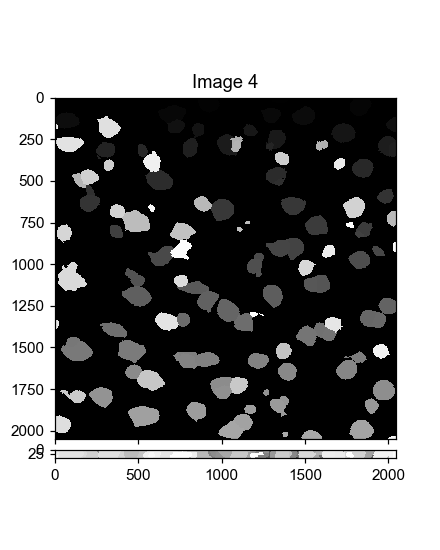

In [13]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])